In [18]:
import pandas as pd
from fastai.tabular import *
from fastai.basic_train import *
from fastai.metrics import *
import numpy as np
import matplotlib.pyplot as plt
import torch, time
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
torch.cuda.set_device(1)

In [ ]:
#download the data
!wget http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip atlas-higgs-challenge-2014-v2.csv.gz

In [9]:
#Read the data (the input file contains ~820k different events)
raw_df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [47]:
#remove unnecessary variables
df = raw_df.drop('EventId',axis=1).drop('Weight',axis=1).drop('KaggleSet',axis=1).drop('KaggleWeight',axis=1)
#keep only PRI_jet_num=2 entries
df = df.loc[df.PRI_jet_num>1].copy()

### Split to training/validation/test

we will split our dataset to three parts.

In [49]:
training_df = df[:150000]
valid_df = df[150000:200000]
test_df = df[200000:]
#lets see how many signal and bkg events we have
for df_i in [training_df,valid_df,test_df]:
    print(len(df_i),' signal: ',len(df_i[df_i.Label=='s']), ' bkg: ',len(df_i[df_i.Label=='b']))
    print('-----')

150000  signal:  67076  bkg:  82924
-----
50000  signal:  22441  bkg:  27559
-----
37985  signal:  16988  bkg:  20997
-----


# Define the variables of the dataset

the dep_var (dependent variable) is what we want to predict,

cat_names stands for "categorical names", variables which describe distinct cateogries
cont_names is "continuous", for variables which are continuous...

we don't HAVE to make this distinction, but it might be usefull, especially in cases with many cateogries (not this one)

In [50]:
dep_var = 'Label'
cat_names = None
cont_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

### Create the dataset object

note we add something called "Categorify" as a "proc"
this is something technical I don't want to get into here, you need it when using categorical variables that are not integers.

In [51]:
valid_idx = range(len(training_df), len(training_df)+len(valid_df))

procs = [Categorify]

data = TabularDataBunch.from_df('.', pd.concat([training_df,valid_df]), dep_var=dep_var, 
                                valid_idx=valid_idx, cat_names=cat_names,
                                cont_names=cont_names,procs=procs,
                               bs=400) #notice the bs = batch size

# Learner (train function)

In ex. 1 we used `Learner()` from [basic_train](https://docs.fast.ai/basic_train.html#Learner) library

note: we defined `loss_func` to be CrossEntropy(), and not BinaryCrossEntropy.

We construct a simple NN, for the propose we will use 4-Layer NN with H = [100,50,10]
![4-Layer NN](images/4L_NN.png)

In [52]:
learn = tabular_learner(data,layers=[100,50,10], 
                        metrics=accuracy,
                        loss_func=nn.CrossEntropyLoss())

### Train and evaluate

Let's construct a simple NN, for the propose we will use 4-Layer NN with H = [100,50,10]
![4-Layer NN](images/4L_NN.png)

if we run the learning rate finder with this model, it obiously does not matter what learning rate we use, since the output is always "background"

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
tic = time.time()
learn.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.361226,0.354725,0.843260,00:03
1,0.348275,0.352812,0.844360,00:03
2,0.351107,0.344343,0.849320,00:03
3,0.349527,0.345243,0.847700,00:03
4,0.343452,0.344030,0.847740,00:03
5,0.341480,0.339408,0.852660,00:03
6,0.334559,0.337325,0.853180,00:03
7,0.342706,0.338183,0.852620,00:04
8,0.339555,0.336643,0.852860,00:03
9,0.333602,0.337398,0.852120,00:03


###  Lets look at the prediction

to run the train function we need to define the loss and optimizer

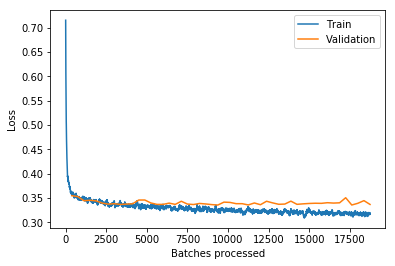

In [62]:
learn.recorder.plot_losses()

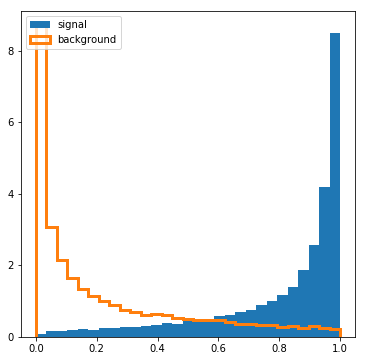

In [64]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)
preds = preds.data.numpy()[:,0]

preds_sig = preds[y.numpy()==0]
preds_bkg = preds[y.numpy()==1]

bins = np.linspace(0,1,30)

fig,ax = plt.subplots(figsize=(6,6))

ax.hist(preds_sig,bins=bins,density=True,label='signal')
ax.hist(preds_bkg,bins=bins,density=True,histtype='step',linewidth=3,label='background')
plt.legend()
plt.show()

# Re-processing

We will repeat all steps, just this time the data will be reprocessed with the "Normalize" transformations


In [65]:
transform = Normalize(cat_names, cont_names)
transform(training_df)
transform.apply_test(valid_df)
transform.apply_test(test_df)

In [75]:
data_norm = TabularDataBunch.from_df('.', pd.concat([training_df,valid_df]), dep_var=dep_var, 
                                valid_idx=valid_idx, cat_names=cat_names,
                                cont_names=cont_names,procs=procs,
                               bs=400) #notice the bs = batch size
learn_norm = tabular_learner(data_norm,layers=[100,50,10], 
                        metrics=accuracy,
                        loss_func=nn.CrossEntropyLoss())

In [76]:
tic = time.time()
learn_norm.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.361526,0.357132,0.842960,00:05
1,0.346934,0.350739,0.845200,00:04
2,0.346320,0.350078,0.844840,00:06
3,0.343398,0.340490,0.851860,00:04
4,0.341285,0.337350,0.853040,00:04
5,0.338962,0.337968,0.853040,00:05
6,0.342319,0.337527,0.852640,00:05
7,0.338258,0.341831,0.850040,00:04
8,0.339085,0.342150,0.850640,00:04
9,0.337175,0.359790,0.837020,00:04


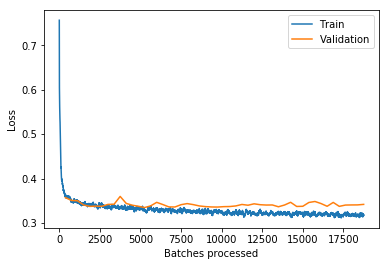

In [77]:
learn_norm.recorder.plot_losses()

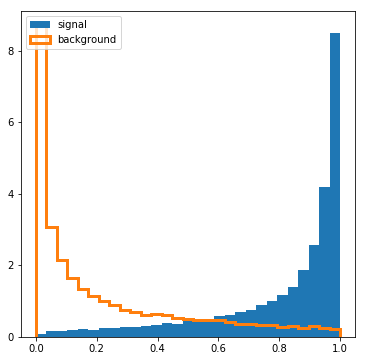

In [78]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)
preds = preds.data.numpy()[:,0]

preds_sig = preds[y.numpy()==0]
preds_bkg = preds[y.numpy()==1]

bins = np.linspace(0,1,30)

fig,ax = plt.subplots(figsize=(6,6))

ax.hist(preds_sig,bins=bins,density=True,label='signal')
ax.hist(preds_bkg,bins=bins,density=True,histtype='step',linewidth=3,label='background')
plt.legend()
plt.show()

# Compare accuracy between two methods

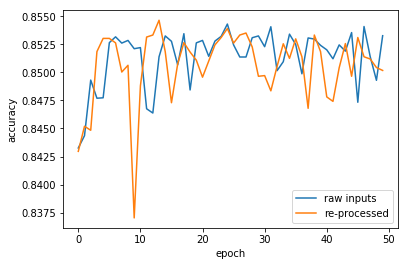

In [79]:
plt.plot(learn.recorder.metrics,label = 'raw inputs')
plt.plot(learn_norm.recorder.metrics,label = 're-processed')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.show()

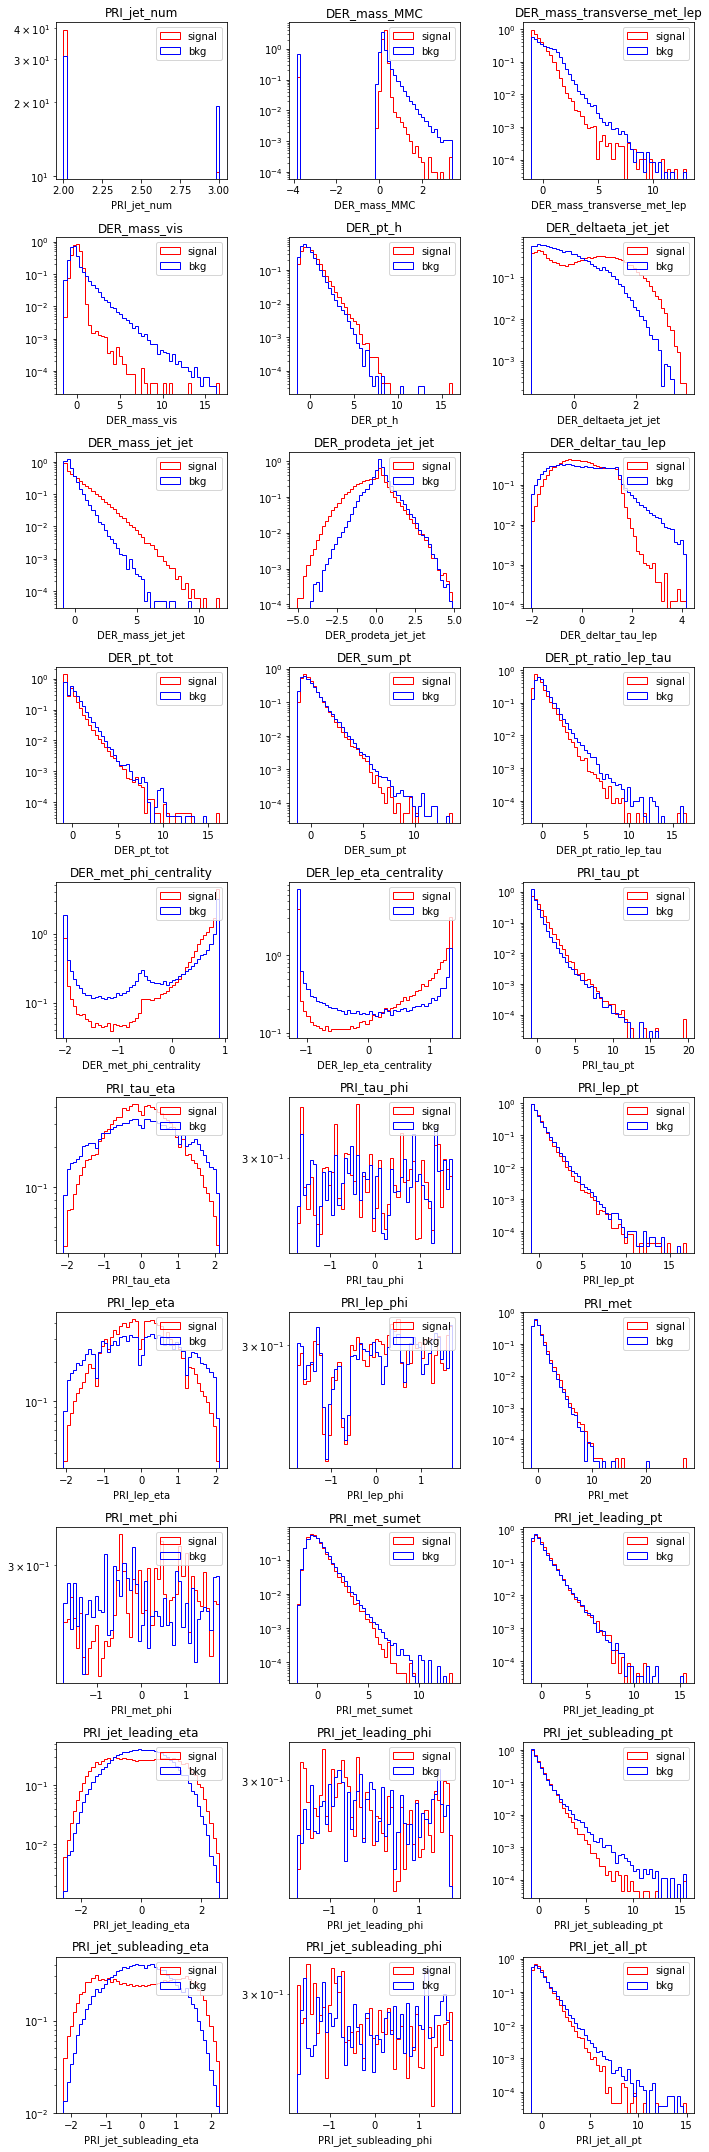

In [74]:
variables = [
     'PRI_jet_num',
        'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


signal_training = training_df[training_df.Label=='s']
bkg_training = training_df[training_df.Label=='b']

fig, ax = plt.subplots(10,3,figsize=(10,30))

varindex = -1
for axlist in ax:
    for ax_i in axlist:
        varindex+=1
        varname = variables[varindex]
        
        h = ax_i.hist(signal_training[varname],
                      bins=50,histtype='step',edgecolor='r',label='signal',density=True)
        binning = h[1]
        ax_i.hist(bkg_training[varname],
                  bins=binning,histtype='step',edgecolor='b',label='bkg',density=True)
        
        ax_i.legend()
        ax_i.set_title(varname)
        ax_i.set_xlabel(varname)
        ax_i.set_yscale('log')
        
plt.tight_layout()
plt.show()